In [23]:
# General imports
import swyft
import torch
import pytorch_lightning as pl
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

from pytorch_lightning.callbacks import Callback
import copy

from getdist import plots, loadMCSamples
import getdist

from itertools import chain
from time      import time
from scipy     import stats
from tqdm import tqdm

torch.cuda.is_available()

from pytorch_lightning.loggers import WandbLogger
#import wandb

In [24]:
varying_nuisance = True
#Fiducial values for (H0, 100*omega_b, omega_c, n_s, ln(10^10A_s), A_IA, eta_IA, beta_IA, b0_poly, b1_poly, b2_poly, b3_poly)
fiducial = np.array([67.,2.2445,0.1205579307,0.96,3.0568,1.72,-0.41,2.17,0.830703,1.190547,-0.928357,0.423292])

#Fiducial values for (H0, 100*omega_b, omega_c, n_s, ln(10^10A_s), A_IA, eta_IA, beta_IA, b_1, b_2, b_3, b_4, b_5, b_6, b_7, b_8, b_9, b_10)
#fiducial = np.array([67.,2.2445,0.1206,0.96,3.0568,1.72,-0.41,2.17,1.09977,1.22025,1.2724,1.31662,1.35812,1.39982,1.44465,1.4965,1.56525,1.74299])

In [25]:
if varying_nuisance == True:
    N_pars = 12
    # Take pre-computed inverse of Fisher matrix and sigma values from Fisher forecast analysis (see cell below)
    Finv = np.array([[ 1.81230634e+00,  2.43869382e-01,  5.30806178e-03,-5.00941549e-03, -2.55253868e-02,  3.16994464e-03,-2.10990714e-03,  7.59245128e-04,  1.99496030e-04,1.42812609e-04, -2.01366640e-03,  7.54589710e-04],
                     [ 2.43869382e-01,  3.42253539e-02,  7.07055977e-04,-6.15055185e-04, -3.21462537e-03,  3.89040318e-04,-3.01034784e-04,  1.00646203e-04,  3.71081185e-05,9.87303111e-05, -3.20210062e-04,  1.17033238e-04],
                     [ 5.30806178e-03,  7.07055977e-04,  1.58645175e-05,-1.54003969e-05, -8.02212968e-05,  8.04720642e-06,-7.15338918e-06,  2.28223609e-06,  1.82232148e-06,8.00526790e-07, -6.82281772e-06,  2.60096559e-06],
                     [-5.00941549e-03, -6.15055185e-04, -1.54003969e-05,1.99260331e-05,  8.28688515e-05, -6.73503170e-06,6.21667745e-06, -2.15479134e-06, -3.10909036e-06,6.13551954e-06,  2.28737629e-06, -1.33721704e-06],
                     [-2.55253868e-02, -3.21462537e-03, -8.02212968e-05,8.28688515e-05,  4.66070707e-04, -3.09045541e-05,4.41604094e-05, -1.18191467e-05, -2.02005894e-05,-8.84803145e-06,  4.38087128e-05, -1.68719581e-05],
                     [ 3.16994464e-03,  3.89040318e-04,  8.04720642e-06,-6.73503170e-06, -3.09045541e-05,  1.13550717e+00,-7.35506018e-01,  2.75988260e-01, -2.31693511e-05,7.18946395e-05, -8.19194015e-05,  2.46627138e-05],
                     [-2.10990714e-03, -3.01034784e-04, -7.15338918e-06,6.21667745e-06,  4.41604094e-05, -7.35506018e-01,4.76584457e-01, -1.78959356e-01,  5.48162017e-06,-5.31134279e-05,  6.17580386e-05, -1.93944496e-05],
                     [ 7.59245128e-04,  1.00646203e-04,  2.28223608e-06,-2.15479133e-06, -1.18191467e-05,  2.75988260e-01,-1.78959356e-01,  6.81046403e-02, -3.64403938e-06,1.81682019e-05, -2.15083821e-05,  6.79856835e-06],
                     [ 1.99496030e-04,  3.71081185e-05,  1.82232148e-06,-3.10909036e-06, -2.02005894e-05, -2.31693511e-05,5.48162017e-06, -3.64403938e-06,  1.44178157e-05,-2.81948705e-05,  2.87686909e-05, -8.53997647e-06],
                     [ 1.42812609e-04,  9.87303111e-05,  8.00526790e-07,6.13551954e-06, -8.84803145e-06,  7.18946395e-05,-5.31134279e-05,  1.81682019e-05, -2.81948705e-05,1.47404926e-04, -1.61031792e-04,  5.19741318e-05],
                     [-2.01366640e-03, -3.20210062e-04, -6.82281772e-06,2.28737629e-06,  4.38087128e-05, -8.19194015e-05,6.17580386e-05, -2.15083821e-05,  2.87686909e-05,-1.61031792e-04,  1.86534602e-04, -6.20032274e-05],
                     [ 7.54589710e-04,  1.17033238e-04,  2.60096559e-06,-1.33721704e-06, -1.68719581e-05,  2.46627138e-05,-1.93944496e-05,  6.79856835e-06, -8.53997647e-06,5.19741318e-05, -6.20032274e-05,  2.11061513e-05]])
    
    sigmas = [1.3462192771991126,0.18500095644733505,0.003983028686562945,0.004463858541713863,0.02158867079257828,1.065601787521897,
              0.6903509662959433,0.2609686577879521,0.00379707989363765,0.012141043054054921,0.013657767078296976,0.004594143146914281]
    
else:
    N_pars = 5
    # Take pre-computed inverse of Fisher matrix and sigma values from Fisher forecast analysis (see cell below)
    Finv = np.array([[ 1.29690667e+00,  1.86070814e-01,  3.67594463e-03,-2.54452425e-03, -1.61995414e-02],
                     [ 1.86070814e-01,  2.75962052e-02,  5.19451347e-04,-3.39312668e-04, -2.10287170e-03],
                     [ 3.67594463e-03,  5.19451347e-04,  1.05158934e-05,-7.49386792e-06, -4.81348850e-05],
                     [-2.54452425e-03, -3.39312668e-04, -7.49386792e-06,7.75526346e-06,  3.69362541e-05],
                     [-1.61995414e-02, -2.10287170e-03, -4.81348850e-05,3.69362541e-05,  2.61090068e-04]])

    sigmas = [1.138818103412835, 0.16612105593550242, 0.003242821821140238, 0.0027848273667033887, 0.016158281709963626]

In [26]:
Nbin_z = 10
Nbin_ell = 30

lmin = 10
lmax = 2000

class Simulator(swyft.Simulator):
    def __init__(self, zmin = 0.01, kmax = 10., bounds = None):

        super().__init__()
        self.transform_samples = swyft.to_numpy32
        
        # These are the specifications of the experiment
        self.specs = {'Solver':'CLASS', #CHOOSE SOLVER here
          'fsky': 0.35,
          'gal_per_arcmin': 30.,
          'sigma_eps': 0.3,
          'Nbin_ell': Nbin_ell,
          'lmin': lmin,
          'lmax': lmax,
          'zmin': zmin,
          'kmax': kmax,           
          'use_obs': {'GC': True, 'WL': True},
          'feedback': False,
          'fixed_covariance': True,
          'varying_nuisance': varying_nuisance} 
        
        self.survey = {'luminosity': './input_files/luminosity_ratio.dat',
        #               'nz': './input_files/nzTabSPV3.dat',
                      'nz': './input_files/nzTabISTF.dat'
                       }
        
        # Own code imports
        if self.specs['Solver'] == 'CLASS':
            from class_interface import Main
        if self.specs['Solver'] == 'CAMB':
            from camb_interface import Main
            
        # Initialize interface with CLASS/CAMB
        self.calculator = Main(self.specs,self.survey)
        # define prior region
        if self.specs['varying_nuisance'] == True:
            self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([60,0.8,0.10,0.91,2.8,1.55,-0.45,1.95,0.75,1.07,-1.02,0.38]), 
                                                                 np.array([15,2.7,0.04,0.12,0.5,0.34,0.08,0.43,0.17,0.24,0.19,0.08])), 
                                                                 bounds = bounds)              
#            self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([60,0.8,0.10,0.91,2.8,1.55,-0.45,1.95,0.9,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.4,1.6]), 
#                                                                 np.array([15,2.7,0.04,0.12,0.5,0.34,0.08,0.43,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])), 
#                                                                 bounds = bounds)  
        else:
            self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([60,0.8,0.10,0.91,2.8]), 
                                                                 np.array([15,2.7,0.04,0.12,0.5])), 
                                                                 bounds = bounds)   
        
        #define the keys for the different spectra
        WLcols = ['L{}xL{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(i,Nbin_z+1)]
        GCcols = ['G{}xG{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(i,Nbin_z+1)]
        XCcols = ['G{}xL{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(1,Nbin_z+1)]
        self.all_cols = WLcols+XCcols+GCcols  
        
        ell_lims    = np.logspace(np.log10(lmin),np.log10(lmax),Nbin_ell)
        self.ells   = 0.5*(ell_lims[:-1]+ell_lims[1:])

        # select fiducial parameters
        if self.specs['Solver'] == 'CLASS':
            self.params_fid = {'output':'mPk',
                          'non linear':'halofit',
                          'omega_b': fiducial[1]*1e-2,
                          'omega_cdm': fiducial[2],
                          'n_s': fiducial[3],
                          'ln10^{10}A_s': fiducial[4],
                          'H0': fiducial[0],
                          'tau_reio': 0.05,
                          'N_ur':2.0328,
                          'N_ncdm':1,
                          'm_ncdm': 0.06,
                          'sBBN file':'/home/abellan/class_repositories/HiClass_Axion_EMG/bbn/sBBN_2017.dat',
#                          'sBBN file':'/Users/gfranco/class_repositories/HiClass_Axion_EMG/bbn/sBBN_2017.dat'
                           }
            
        if self.specs['Solver'] == 'CAMB':
            self.params_fid = {'ombh2': fiducial[1]*1e-2,
                          'omch2': fiducial[2],
                          'ns': fiducial[3],
                          'As': np.exp(fiducial[4])*1e-10,
                          'H0': fiducial[0],
                          'tau': 0.05,
                          'w': -1.,
                          'wa': 0.,
                          'mnu': 0.06,
                          'dark_energy_model':'ppf'}
                
        #Update with list of nuisance parameters
        self.params_fid.update({'A_IA': fiducial[5],'eta_IA': fiducial[6],'beta_IA': fiducial[7],
                                'b0_poly': fiducial[8],'b1_poly': fiducial[9],'b2_poly': fiducial[10],'b3_poly': fiducial[11]})        
#        self.params_fid.update({'A_IA': fiducial[5],'eta_IA': fiducial[6],'beta_IA': fiducial[7],
#                               'b_1': fiducial[8],'b_2': fiducial[9],'b_3': fiducial[10],'b_4': fiducial[11],
#                               'b_5': fiducial[12],'b_6': fiducial[13],'b_7': fiducial[14],'b_8': fiducial[15],
#                               'b_9': fiducial[16],'b_10':fiducial[17]})

            
        #obtain covmat for fiducial spectra
        self.observables_fid = self.calculator.get_calculations(self.params_fid)
        self.Cls_fid = self.observables_fid.Cls
        self.covmat_fid, self.noisy_Cls_fid = self.calculator.get_noisy_Cls(self.Cls_fid)
        
        self.L_fid = {}
        for ind,ell in enumerate(self.ells):
            self.L_fid[str(int(ell))] = torch.linalg.cholesky(torch.tensor(self.covmat_fid[str(int(ell))].values).double())
      
    def get_sample_Cls(self,z):

        #Select cosmo parameters
        if self.specs['Solver'] == 'CLASS':
            self.params = {'output':'mPk',
                      'non linear':'halofit',
                      'omega_b': z[1]*1e-2,
                      'omega_cdm': z[2],
                      'n_s': z[3],
                      'ln10^{10}A_s': z[4],
                      'H0': z[0],
                      'tau_reio': 0.05,
                      'N_ur':2.0328,
                      'N_ncdm':1,
                      'm_ncdm': 0.06,
                      'sBBN file':'/home/abellan/class_repositories/HiClass_Axion_EMG/bbn/sBBN_2017.dat',
#                      'sBBN file':'/Users/gfranco/class_repositories/HiClass_Axion_EMG/bbn/sBBN_2017.dat'
                       }

        if self.specs['Solver'] == 'CAMB':
            self.params = {'ombh2': z[1]*1e-2,
                      'omch2': z[2],
                      'ns': z[3],
                      'As': np.exp(z[4])*1e-10,
                      'H0': z[0],
                      'tau': 0.05,
                      'w': -1.,
                      'wa': 0.,
                      'mnu': 0.06,
                      'dark_energy_model':'ppf'}    

        #Update with list of nuisance parameters
        if self.specs['varying_nuisance'] == True:
            self.params.update({'A_IA': z[5],'eta_IA': z[6],'beta_IA': z[7],
                                'b0_poly': z[8],'b1_poly': z[9],'b2_poly': z[10],'b3_poly': z[11]})        
#            self.params.update({'A_IA': z[5],'eta_IA': z[6],'beta_IA': z[7],
#                                'b_1': z[8],'b_2': z[9],'b_3': z[10],'b_4': z[11],'b_5': z[12],
#                                'b_6': z[13],'b_7': z[14],'b_8': z[15],'b_9': z[16],'b_10':z[17]})
            
        else:
            self.params.update({'A_IA': fiducial[5],'eta_IA': fiducial[6],'beta_IA': fiducial[7],
                                'b0_poly': fiducial[8],'b1_poly': fiducial[9],'b2_poly': fiducial[10],'b3_poly': fiducial[11]})            
#            self.params.update({'A_IA': fiducial[5],'eta_IA': fiducial[6],'beta_IA': fiducial[7],
#                                'b_1': fiducial[8],'b_2': fiducial[9],'b_3': fiducial[10],'b_4': fiducial[11],
#                                'b_5': fiducial[12],'b_6': fiducial[13],'b_7': fiducial[14],'b_8': fiducial[15],
#                                'b_9': fiducial[16],'b_10':fiducial[17]})
            
        
        #compute un-noised C_ells spectra
        self.observables = self.calculator.get_calculations(self.params)
        self.Cls = self.observables.Cls    
        self.Cls.pop('ells')
        #Note: cls is a dictionary, but in the swyft simulator we need to have numpy arrays as the output of the graph.nodes            
        vals_Cls = np.array(list(self.Cls.values))
        return vals_Cls.transpose()
    
    def get_realization(self,Lfids,cols): 
        ell_realization = []
        for ind,ell in enumerate(self.ells):
            L_fid = Lfids[str(int(ell))] 
            means  = torch.zeros(len(L_fid)).double()
            dist = torch.distributions.multivariate_normal.MultivariateNormal(means, scale_tril = L_fid)
            sample = dist.sample().numpy()
            ell_realization.append({key: sample[ind] for ind,key in enumerate(cols)})
        realization = {key: np.array([d[key] for d in ell_realization]) for key in ell_realization[0].keys()}
        return realization
    
    def get_sample_noise(self):
#        self.noise = self.get_realization(self.L_fid,self.all_cols)
        self.noise = self.calculator.get_realization(None,self.covmat_fid,self.all_cols)
        vals_noise = np.array(list(self.noise.values()))
        return vals_noise


    def build(self, graph):
        z = graph.node('z', self.sample_z)
        C_ells = graph.node('C_ells', self.get_sample_Cls, z) #compute un-noised Cls
        noise  = graph.node('noise', self.get_sample_noise) # get the noise, we will add it to the un-noised Cls later

In [27]:
bounds = []
for i in range(N_pars):
    bounds.append([fiducial[i]-5*sigmas[i],fiducial[i]+5*sigmas[i]])
bounds = np.array(bounds)
    
if False:    
    sim = Simulator(bounds = bounds)
    shapes, dtypes = sim.get_shapes_and_dtypes()
    print("shapes:", shapes)
    print("dtypes:", dtypes)

In [28]:
if False:
    # generate mock data from fiducial model (and save it)
    obs = sim.sample(conditions = {'z': fiducial})
    np.save('./obs_data.npy',obs, allow_pickle=True) 

In [29]:
# read pre-computed observed data
obs = np.load('./obs_data.npy',allow_pickle=True).item()

FileNotFoundError: [Errno 2] No such file or directory: './obs_data.npy'

In [30]:
# Let's perform Fisher analysis, in order to get an estimate of the 1sigma errors of the 1d posteriors
# We will use this to have a good guess for the prior boundaries: [fiducial-5*sigma, fiducial+5*sigma]
# (note that for the moment we will not do a sequence of truncated rounds)
# Later, we will also use Fisher analysis to compare against posteriors obtained by Swyft

if False:
    def finiteD(i, eps=1e-2):
        fiducial_1 = list(fiducial)
        fiducial_1[i] = fiducial[i]*(1+eps)
        fiducial_2 = list(fiducial)
        fiducial_2[i] = fiducial[i]*(1-eps)
        C1 = sim.sample(conditions = {'z': fiducial_1},targets = ['C_ells'])
        C2 = sim.sample(conditions = {'z': fiducial_2},targets = ['C_ells'])
        Num_spec = Nbin_z*(2*Nbin_z+1)
        output = np.zeros((Nbin_ell-1,Num_spec))
        for ell in range(Nbin_ell-1):
            output[ell,:] = [(C1['C_ells'][idx_spec,ell] - C2['C_ells'][idx_spec,ell])/(fiducial[i]*(2*eps)) for idx_spec in range(Num_spec)]
        return output

    ders = [finiteD(i) for i in range(N_pars)] #compute numerical derivatives

    ell_lims = np.logspace(np.log10(lmin), np.log10(lmax), Nbin_ell)
    ells = 0.5*(ell_lims[:-1]+ell_lims[1:])
    # compute Fisher matrix
    F = np.zeros((N_pars,N_pars))
    for i in range(N_pars):
        for j in range(N_pars):
            d1=ders[i]
            d2=ders[j]
            term = 0.
            for ellind,ell in enumerate(ells):
                covmat = sim.covmat_fid[str(int(ell))]
                icovmat = np.linalg.inv(covmat)
                term += np.dot(d1[ellind,:],np.matmul(icovmat,d2[ellind,:]))
            F[i,j] = term

    Finv=np.linalg.inv(F)
    sigmas=[]
    for i in range(N_pars): sigmas.append(np.sqrt(Finv[i,i]));

In [9]:
# create ZarrStore (or read it if it was already created)
#store = swyft.ZarrStore("./Euclid_zarr_store_5e4sims_var_nuisance") 
store = swyft.ZarrStore("./Euclid_zarr_store_5e4sims") 
store = store.get_sample_store()

if False:
    from joblib import Parallel, delayed
    import psutil

    store.init(50_000, 64, shapes, dtypes)  
    def simulate_parallel(sim):
        store.simulate(sim,max_sims=64, batch_size = 64)        
    njobs = psutil.cpu_count(logical=True) 
    while store.sims_required > 0:
        Parallel(n_jobs=njobs)(delayed(simulate_parallel)(sim) for _ in range(njobs))

In [10]:
# Useful for plotting results of the Fisher analysis
def normal_dist(x , mean , sd):
    prob_density =  1/(sd*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def ellipse(x,ind_x,ind_y,delta_chi2,loc):
    n1 = [ind_y,ind_x]
    n2 = [ind_y,ind_x]
    Ginv = Finv[np.meshgrid(n1,n2, sparse=True, indexing='ij')]
    G=np.linalg.inv(Ginv)
    det = np.linalg.det(G)
    discrim = delta_chi2*G[0,0] - det*x**2
    if loc == 'up':
        y = (-G[0,1]*x + np.sqrt(discrim))/G[0,0]
    else:
        y = (-G[0,1]*x - np.sqrt(discrim))/G[0,0]
    return y

In [11]:
# Define network here
class Network(swyft.AdamWReduceLROnPlateau,swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-3
        self.batch_size = 256 
        num_feat_tot = 2 # number of features per parameter
        self.num_feat_spec = 5 #number of features per spectra
        Nbin_z = 10
        self.num_spectra = Nbin_z*(2*Nbin_z+1)
        self.nbin_ell = 30
        self.eps = 1e-50 #very small number to avoid nan

        self.norm =  swyft.networks.OnlineStandardizingLayer((self.num_spectra, self.nbin_ell-1), epsilon=self.eps)

        self.sequential = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.LazyLinear(10),
            torch.nn.LazyBatchNorm1d()
        )
        
        self.p_compressor = torch.nn.Sequential(
            swyft.networks.LinearWithChannel(210, 29, 64),
            torch.nn.ReLU(),
            swyft.networks.LinearWithChannel(210, 64, 64),
            torch.nn.ReLU(),
            swyft.networks.LinearWithChannel(210, 64, 16)
        )
        
        self.full = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.LazyLinear(1024),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(1024),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(10)
        )


        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = num_feat_tot, num_params = 5, varnames = 'z', num_blocks = 4, dropout = 0.2)
        self.marginals  = ((0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),)
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 4, marginals = self.marginals, varnames = 'z',num_blocks = 4, dropout = 0.2)

    def forward(self, A, B):
        
        s = A['C_ells']+A['noise']
        s = self.norm(s*1e20)
        
        s = self.p_compressor(s)
        s = self.sequential(s)
        #s = self.full(s)
        
        z = B['z']
#        z = B['z'][...,:5]
        s1 = s.reshape(-1, 5, 2)  # Use two features per 1-dim marginal (B, 5, 2)
        s2 = torch.stack([torch.cat([s1[:, i, :], s1[:, j, :]], dim = -1) for i, j in self.marginals], dim = 1)  # Use two+two features per 2-dim marginal (B, 10, 4)
        logratios1 = self.logratios1(s1, z)
        logratios2 = self.logratios2(s2, z)
        return logratios1, logratios2

In [12]:
def resampler(x):
    i = np.random.randint(50000, size = (210,)) #list of 210 integers uniformly distributed between 0 and 50000-1
    noise = np.array([store['noise'][j][k] for k, j in enumerate(i)]) # k in [0,209], j in [0,50000-1]
    x['noise'] = noise
    return x

In [13]:
# Perform inference

wandb.init(reinit = True, project = 'Euclid', group = 'exp10', name = 'test1')
wandb_logger = WandbLogger(log_model='all')
#wandb_logger = None

network = Network()
dm = swyft.SwyftDataModule(store, num_workers = 3, batch_size = network.batch_size, on_after_load_sample=resampler)


#model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1) # save best model according to val_loss
#early_stopping = pl.callbacks.EarlyStopping("val_loss", patience=8,verbose = True)

max_epochs = -1 #infinite training
trainer = swyft.SwyftTrainer(accelerator = 'cuda', devices=1, max_epochs = max_epochs, precision = 64,logger = wandb_logger)
#                            ,callbacks = [model_checkpoint,early_stopping])

#network.load_from_checkpoint("./lightning_logs/version_3987973/checkpoints/epoch=49-step=27350.ckpt") #load best model
trainer.fit(network, dm)

wandb: Currently logged in as: g-francoabellan (grappa). Use `wandb login --relogin` to force relogin


/home/abellan/.local/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/home/abellan/.local/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/9avnrh1y/checkpoints/epoch=27-step=4396.ckpt


In [14]:
#network.load_from_checkpoint("./lightning_logs/version_3987973/checkpoints/epoch=49-step=27350.ckpt") #load best model
#prior_samples = sim.sample(N = 10_000, targets = ['z'])
prior_samples = swyft.Samples(z = stats.uniform(np.array([fiducial[0]-5*sigmas[0],fiducial[1]-5*sigmas[1],
                                                          fiducial[2]-5*sigmas[2],fiducial[3]-5*sigmas[3],
                                                          fiducial[4]-5*sigmas[4]]), 
                                                          np.array([10*sigmas[0],10*sigmas[1],
                                                                    10*sigmas[2],10*sigmas[3],
                                                                    10*sigmas[4]])).rvs(size=(500_000,5)))

predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 157it [00:00, ?it/s]

/home/abellan/.local/lib/python3.7/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [15]:
obs_p = swyft.Sample(dict(C_ells=obs['C_ells'], noise=0.*store[5000]['noise']))
#obs_p = obs
predictions = trainer.infer(network, obs_p, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 157it [00:00, ?it/s]

In [16]:
# Taken from Matteo's notebook S-CLOE_results.ipynb, this is used to post-process MCMC chains with Getdist

chains = {'fixnuis': {'path': './MCMC_chains_matteo/test_3x2pt_fixnuis','burn_in': 0.3,'Nchains': 4}}

def analyze_chain(name,chain):
    sample = loadMCSamples(chain['path'], settings={'ignore_rows': chain['burn_in']})
    p = sample.getParams()
    p.ombh2_100 = 100.*p.ombh2
    sample.addDerived(p.ombh2_100, name='ombh2_100', label='ombh2_100')
    chain['sample'] = sample
    return chain

plot_pars = ['H0','ombh2_100','omch2','ns','logA']

# get post-processed chains
chains = {name: analyze_chain(name,chain) for name,chain in chains.items()}
LCDM_3x2pt = [chain['sample'] for chain in chains.values()]

#create instance of single_plotter just to be able to plot 1d posteriors from the MCMC later
g = plots.get_single_plotter(width_inch=8) 

/home/abellan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == "__main__":
/home/abellan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/home/abellan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  


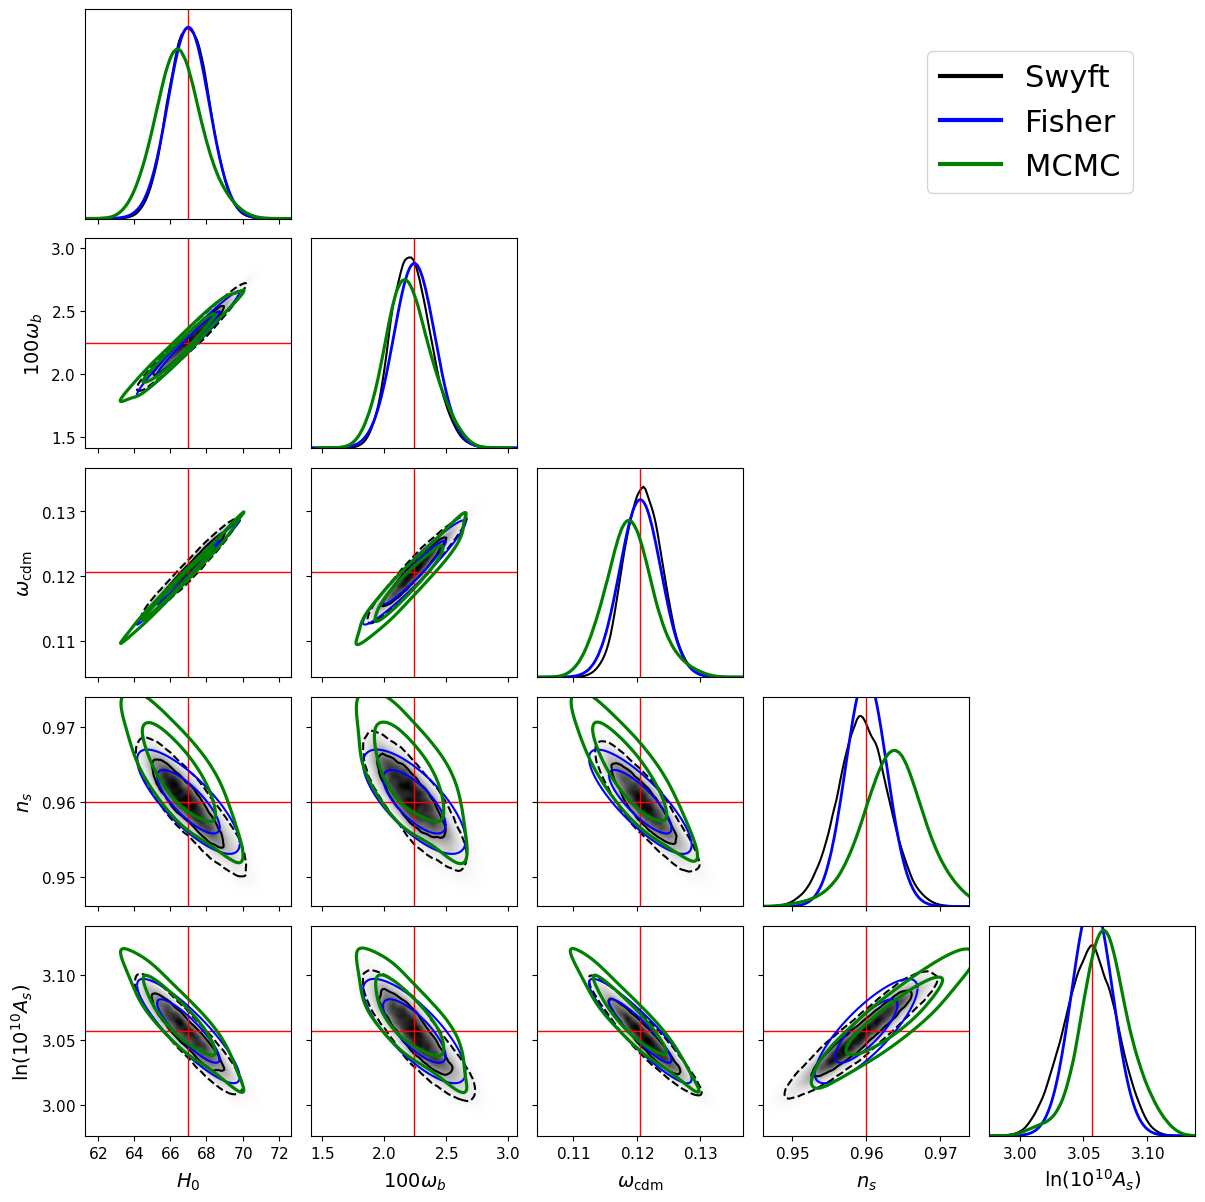

In [18]:
%matplotlib inline

show_Fisher = True
show_MCMC = True

# plot the posteriors here (we compare Swyft and Fisher)
fig, axes = plt.subplots(5, 5, figsize=(12,12))

# corner plot with swyft predictions
swyft.plot_corner(predictions, ('z[0]', 'z[1]', 'z[2]','z[3]','z[4]'),fig=fig, bins = 100, smooth = 1,contours_1d=False)


for i in range(5): # plot 1D posteriors from Fisher and MCMC
    #fiducial 
    axes[i, i].axvline(obs['z'][i], color='red',lw=1.)
    #Fisher
    if show_Fisher:
        vec = np.sort(prior_samples['z'][:500,i])
        axes[i, i].plot(vec,1*normal_dist(vec ,fiducial[i] , sigmas[i]),color='b',lw=2.)
    #MCMC
    if show_MCMC:
        g.plot_1d(LCDM_3x2pt, plot_pars[i], ax = axes[i,i],colors=['green'],normalized='True',no_ylabel='True',lims=[bounds[i,0],bounds[i,1]])


for i,j in network.marginals: # PLOT 2D posteriors from Fisher and MCMC
    # fiducial
    axes[j, i].axvline(obs['z'][i], color='red',lw=1.)
    axes[j, i].axhline(obs['z'][j], color='red',lw=1.)
    #Fisher
    if show_Fisher:
        x = np.linspace(-5*sigmas[i],5*sigmas[i],1000)
        axes[j, i].plot(x+fiducial[i],ellipse(x,i,j,2.3,'up')+fiducial[j],color ='b' )
        axes[j, i].plot(x+fiducial[i],ellipse(x,i,j,2.3,'down')+fiducial[j],color ='b')
        axes[j, i].plot(x+fiducial[i],ellipse(x,i,j,6.2,'up')+fiducial[j],color ='b' )
        axes[j, i].plot(x+fiducial[i],ellipse(x,i,j,6.2,'down')+fiducial[j],color ='b')
    #MCMC
    if show_MCMC:
        g.plot_2d(LCDM_3x2pt, plot_pars[i], plot_pars[j],ax = axes[j,i], colors=['green'],lims = [bounds[i,0],bounds[i,1], bounds[j,0],bounds[j,1]])

    
#add labels 
fontsize = 14
axes[4, 0].set_xlabel(r'$H_0$',fontsize = fontsize)
axes[4, 1].set_xlabel(r'$100 \omega_b$',fontsize = fontsize)
axes[4, 2].set_xlabel(r'$\omega_{\mathrm{cdm}}$',fontsize = fontsize)
axes[4, 3].set_xlabel(r'$n_s$',fontsize = fontsize)
axes[4, 4].set_xlabel(r'$\mathrm{ln}(10^{10}A_s)$',fontsize = fontsize)

axes[1, 0].set_ylabel(r'$100 \omega_b$',fontsize = fontsize)
axes[2, 0].set_ylabel(r'$\omega_{\mathrm{cdm}}$',fontsize = fontsize)
axes[3, 0].set_ylabel(r'$n_s$',fontsize = fontsize)
axes[4, 0].set_ylabel(r'$\mathrm{ln}(10^{10}A_s)$',fontsize = fontsize)

# add legend
labels = ['Swyft']
colors = ['black']
if show_Fisher:
    labels.append('Fisher')
    colors.append('blue')
if show_MCMC:
    labels.append('MCMC')
    colors.append('green')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
plt.legend(lines, labels,loc=(-0.3,4.5),fontsize=22)

# This is only required because we are comparing with results from MCMC using getdist... 
# when using g.plot_1d and g.plot_2d, this adds unwanted ticks and labels in the middle subplots of the corner plot
# so we have to manually remove ticks and labels
if show_MCMC:
    for i in range(1,3):
        axes[3, i].set_xlabel(None)
        axes[3, i].set_ylabel(None)
        axes[3, i].set_xticklabels([])
        axes[3, i].set_yticklabels([])

    axes[2, 1].set_xlabel(None)
    axes[2, 1].set_ylabel(None)
    axes[2, 1].set_xticklabels([])
    axes[2, 1].set_yticklabels([])

    for i in range(1,4): 
        axes[4, i].set_ylabel(None)
        axes[4, i].set_yticklabels([])
        axes[i, i].set_xlabel(None)
        axes[i, i].set_xticklabels([])

    for i in range(4):
        axes[i, 0].set_xlabel(None)
        axes[i, 0].set_xticklabels([])
        
plt.savefig('Swyft_vs_MCMC.pdf')

In [19]:
wandb.log({"Corner plot": wandb.Image(fig)})
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▂▂▁▂▂▁▁▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅▅█▄▃▄▃▃▃▂▂▂▂▁▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,-14.08277
trainer/global_step,5180
val_loss,-14.16537
